### Movie Review Binary Classifier Using Voting Classifier Approach

This notebook creates a binary sentiment classifier for movie reviews using various machine learning models, combined in a voting classifier. The dataset contains positive and negative movie reviews, and the classifier predicts whether a review is positive or negative.

#### Downloading required packages

In [1]:
!pip install pandas scikit-learn matplotlib seaborn

#### Importing the required libraries

In [2]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#### Data Loading

In [3]:
pos_file = './rt-polaritydata/rt-polaritydata/rt-polarity.pos'
neg_file = './rt-polaritydata/rt-polaritydata/rt-polarity.neg'

In [4]:
with open(neg_file, 'r', encoding='latin-1') as neg_f:
    neg_reviews = neg_f.readlines()

with open(pos_file, 'r', encoding='latin-1') as pos_f:
    pos_reviews = pos_f.readlines()

In [5]:
neg_df = pd.DataFrame(neg_reviews, columns=["Review"])
neg_df['class'] = 0
pos_df = pd.DataFrame(pos_reviews, columns=["Review"])
pos_df['class'] = 1

#### Data Preparation

In this section we divide the data into train, test and validation sets:
- Training set: First 4,000 positive and first 4,000 negative reviews
- Validation set: Next 500 positive and next 500 negative reviews
- Test set: Remaining 831 positive and 831 negative reviews

In [6]:
train_data = pd.concat([neg_df.iloc[:4000], pos_df.iloc[:4000]])
val_data = pd.concat([neg_df.iloc[4000:4500], pos_df.iloc[4000:4500]])
test_data = pd.concat([neg_df.iloc[4500:], pos_df.iloc[4500:]])

In [7]:
X_train, y_train = train_data['Review'], train_data['class']
X_val, y_val = val_data['Review'], val_data['class']
X_test, y_test = test_data['Review'], test_data['class']

#### Preprocessing the Text

This cell applies TF-IDF vectorization to convert text data into numerical features. It fits and transforms the training data using `TfidfVectorizer(max_features=5000)` and then applies the same transformation to the validation and test data, ensuring consistent feature extraction.

In [8]:
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)

#### Ensemble of RandomForest and Naive Bayes with soft voting

These cells set up two classifiers: RandomForestClassifier with 100 trees and MultinomialNB (Naive Bayes), with the RandomForest initialized with a random state of 42. We then combine them into a VotingClassifier that uses soft voting to average their predicted probabilities for the final decision.

In [9]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
nb_clf = MultinomialNB()

In [10]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('nb', nb_clf)],
    voting='soft'
)

This cell trains the VotingClassifier on the training data, using `X_train` for features and `y_train` for labels.

In [11]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('nb', MultinomialNB())],
                 voting='soft')

#### Evaluate Model Performance on the Validation Set
In this cell, the performance of the trained voting classifier is evaluated on the validation set using key metrics: Precision, Recall, and F1-score. These metrics provide insights into the model's ability to correctly classify positive reviews (precision), capture all positive reviews (recall), and balance both aspects (F1-score). This evaluation helps to assess how well the model generalizes to unseen data before final testing.


In [12]:
val_pred = voting_clf.predict(X_val)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_pred, average='binary')

val_precision = val_precision * 100
val_recall = val_recall * 100
val_f1 = val_f1 * 100

print("Validation Set Performance:")
print(f"Precision: {val_precision:.3f}%")
print(f"Recall: {val_recall:.3f}%")
print(f"F1-score: {val_f1:.3f}%")

Validation Set Performance:
Precision: 76.892%
Recall: 75.200%
F1-score: 76.036%


#### Final Evaluation on the Test Set
This cell evaluates the final model on the test set, which was kept untouched during training and validation. The confusion matrix is used to derive the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). The key performance metrics—Precision, Recall, and F1-score—are calculated to assess the model's overall effectiveness in classifying unseen data. These metrics provide a reliable estimate of the model's real-world performance.


In [13]:
y_pred = voting_clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
precision = precision * 100
recall = recall * 100
f1 = f1 * 100

print("\nFinal Performance Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Precision: {precision:.3f}%")
print(f"Recall: {recall:.3f}%")
print(f"F1-score: {f1:.3f}%")


Final Performance Metrics:
True Positives (TP): 624
True Negatives (TN): 646
False Positives (FP): 185
False Negatives (FN): 207
Precision: 77.132%
Recall: 75.090%
F1-score: 76.098%


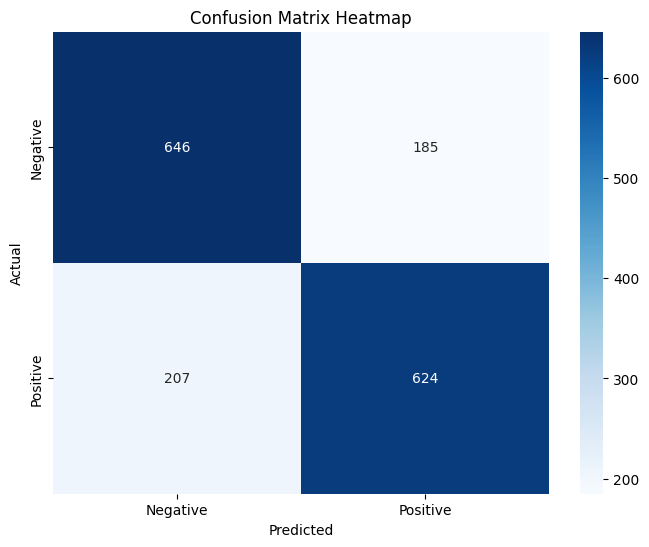

<Figure size 640x480 with 0 Axes>

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('confusion_matrix_heatmap.png', bbox_inches='tight', dpi=300)  # Adjust dpi for better quality
